In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

import optuna

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE

import joblib
import re

In [3]:
train_df = pd.read_csv("creditscore/train.csv", low_memory=False)

## Data Preparation

In [4]:
train_df.shape

(100000, 28)

In [5]:
train_df.sample(30)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
12754,0x60bc,CUS_0x4b6a,March,Kristenx,30,560-37-5114,Developer,8958.715,822.559583,4,...,_,2133.24,24.057443,19 Years and 9 Months,NM,23.253705,35.48132562494031,Low_spent_Small_value_payments,313.52092765610905,Poor
22604,0x9a72,CUS_0x6276,May,NaN,36,231-43-8275,Media_Manager,110147.52,9040.960000,6,...,Standard,1238.2,40.459559,16 Years and 9 Months,Yes,225.068231,207.92255759882573,!@9#%8,711.1052111742813,Standard
81327,0x1f285,CUS_0x83d7,August,NaN,35,677-56-4737,Architect,21709.07_,NaN,3,...,Good,1047.3,29.567058,24 Years and 8 Months,No,0.000000,30.15806984963623,High_spent_Medium_value_payments,427.65084681703047,Good
56581,0x16187,CUS_0x3d99,June,NaN,46_,776-42-6105,Accountant,167258.04,12986.315524,5,...,Good,476.64,29.757926,27 Years and 0 Months,No,1213.854476,608.9695353463228,Low_spent_Large_value_payments,1081.0474646536773,Good
96766,0x24cfc,CUS_0x206b,July,Claras,20,600-69-4533,Entrepreneur,47641.53,4194.127500,7,...,Bad,2150.59,27.447534,15 Years and 5 Months,Yes,161.747685,NaN,High_spent_Large_value_payments,415.02618719434656,Poor
60407,0x177f1,CUS_0x1aee,August,Klaymanp,26,065-68-6043,Accountant,100465.13999999998,8279.095000,4,...,Good,990.2,31.267312,32 Years and 10 Months,No,0.000000,409.242246085755,Low_spent_Medium_value_payments,698.667253914245,Standard
13099,0x62c1,CUS_0x4518,April,"""Johnc",15,958-03-1352,Developer,60532.5,4892.375000,6,...,Standard,1475.77,37.559387,6 Years and 6 Months,Yes,158.028837,306.3817413744108,Low_spent_Large_value_payments,294.82692152068483,Standard
43063,0x11251,CUS_0x1440,August,Jinq,19,807-69-2993,Teacher,7780.49_,368.374167,8,...,Bad,4108.42,35.147265,12 Years and 9 Months,Yes,38.107871,19.930898272426518,Low_spent_Large_value_payments,248.79864729487448,Standard
11193,0x5797,CUS_0x24e3,February,Daniel Alvarengas,35,891-36-8798,_______,22410.53,2071.544167,7,...,Standard,33.85,40.897264,29 Years and 3 Months,Yes,31.839414,129.87256017940078,High_spent_Small_value_payments,305.44244218786514,Standard
64596,0x1907e,CUS_0xb0ca,May,Lopezo,33,320-74-7615,Accountant,20668.71,1993.392500,5,...,_,2272.74,24.269937,7 Years and 11 Months,Yes,73.810903,168.81679413380027,Low_spent_Small_value_payments,246.71155239381451,Poor


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [7]:
train_df.nunique()

ID                          100000
Customer_ID                  12500
Month                            8
Name                         10139
Age                           1788
SSN                          12501
Occupation                      16
Annual_Income                18940
Monthly_Inhand_Salary        13235
Num_Bank_Accounts              943
Num_Credit_Card               1179
Interest_Rate                 1750
Num_of_Loan                    434
Type_of_Loan                  6260
Delay_from_due_date             73
Num_of_Delayed_Payment         749
Changed_Credit_Limit          4384
Num_Credit_Inquiries          1223
Credit_Mix                       4
Outstanding_Debt             13178
Credit_Utilization_Ratio    100000
Credit_History_Age             404
Payment_of_Min_Amount            3
Total_EMI_per_month          14950
Amount_invested_monthly      91049
Payment_Behaviour                7
Monthly_Balance              98792
Credit_Score                     3
dtype: int64

## Data Preparation

### Missing and duplicated values

In [8]:
train_df.isnull().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [9]:
train_df[train_df.duplicated()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


## Data Cleaning

In [10]:
numerical_columns = ['Age',
                     'Annual_Income',
                     'Monthly_Inhand_Salary',
                     'Num_Bank_Accounts',
                     'Num_Credit_Card',
                     'Interest_Rate',
                     'Num_of_Loan',
                     'Delay_from_due_date',
                     'Num_of_Delayed_Payment',
                     'Changed_Credit_Limit',
                     'Num_Credit_Inquiries',
                     'Outstanding_Debt',
                     'Credit_Utilization_Ratio',
                     'Credit_History_Age',
                     'Total_EMI_per_month',
                     'Amount_invested_monthly',
                     'Monthly_Balance']

In [11]:
categorical_columns = [
    "Occupation",
    "Credit_Mix",
    "Payment_of_Min_Amount",
    "Payment_Behaviour",
    "Credit_Score",
    "Month",
    "auto_loan",
    "credit-builder_loan",
    "debt_consolidation_loan",
    "home_equity_loan",
    "mortgage_loan",
    "unspecified_loan",
    "payday_loan",
    "personal_loan",
    "student_loan"
]

In [12]:
def clean_type_of_loan(frame):
    frame["auto_loan"] = frame["Type_of_Loan"].str.lower().str.contains("auto loan").astype(bool)
    frame["credit-builder_loan"] = frame["Type_of_Loan"].str.lower().str.contains("credit-builder loan").astype(bool)
    frame["debt_consolidation_loan"] = frame["Type_of_Loan"].str.lower().str.contains("debt consolidation loan").astype(bool)
    frame["home_equity_loan"] = frame["Type_of_Loan"].str.lower().str.contains("home equity loan").astype(bool)
    frame["mortgage_loan"] = frame["Type_of_Loan"].str.lower().str.contains("mortgage loan").astype(bool)
    frame["unspecified_loan"] = frame["Type_of_Loan"].str.lower().str.contains("not specified").astype(bool)
    frame["payday_loan"] = frame["Type_of_Loan"].str.lower().str.contains("payday loan").astype(bool)
    frame["personal_loan"] = frame["Type_of_Loan"].str.lower().str.contains("personal loan").astype(bool)
    frame["student_loan"] = frame["Type_of_Loan"].str.lower().str.contains("student loan").astype(bool)
    return frame

In [13]:
def clean_credit_age(age):
    if age == 'nan':
        return np.nan
    if not "Years" in age:
        return age
    years, months = age.split(" Years and ")
    months = months.replace(" Months", "")
    return int(years) + int(months) / 12

In [14]:
def clean_outliers(frame):
    frame.loc[frame["Age"] > 65, "Age"] = 65
    frame.loc[frame["Num_Bank_Accounts"] > 1000, "Num_Bank_Accounts"] = 1000
    frame.loc[frame["Monthly_Balance"] > 1e6, "Monthly_Balance"] = np.nan
    return frame

In [15]:
def clean_data(frame, is_test=False):
    numeric_object_columns = ['Age', 'Annual_Income', 'Delay_from_due_date', 'Num_of_Loan', 'Num_of_Delayed_Payment',
                              'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']
    for col in numeric_object_columns:
        frame[col] = frame[col].astype(str).str.replace(r'[^\d\.]', '', regex=True)
        frame[col] = pd.to_numeric(frame[col], errors="coerce")
    frame["Credit_History_Age"] = frame["Credit_History_Age"].astype(str).apply(clean_credit_age)
    frame["Credit_History_Age"] = pd.to_numeric(frame["Credit_History_Age"], errors="coerce")

    frame = clean_type_of_loan(frame)

    frame = clean_outliers(frame)

    frame["Occupation"] = frame["Occupation"].astype(str).str.replace("_______", "")
    frame["Occupation"] = frame["Occupation"].astype(str).str.replace("nan", "")
    frame["Payment_Behaviour"] = frame["Payment_Behaviour"].astype(str).str.replace("!@9#%8", "")
    frame["Payment_Behaviour"] = frame["Payment_Behaviour"].astype(str).str.replace("nan", "")
    frame = frame.drop_duplicates()

    frame = frame.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN', "Type_of_Loan"], axis=1)

    frame.loc[frame["Num_Bank_Accounts"] < 0, "Num_Bank_Accounts"] = np.nan

    for f in frame.columns:
        if is_test and f == "Credit_Score":
            break
        if f in numerical_columns:
            frame[f].fillna(frame[f].median(), inplace=True)
        else:
            frame[f].fillna(frame[f].mode()[0], inplace=True)

    return frame

In [16]:
train_df = clean_data(train_df)

In [17]:
train_df.isnull().sum()

Month                       0
Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
auto_loan                   0
credit-builder_loan         0
debt_consolidation_loan     0
home_equity_loan            0
mortgage_loan               0
unspecified_loan            0
payday_loan                 0
personal_loan               0
student_loan                0
dtype: int64

In [18]:
train_df[train_df.duplicated()]

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Credit_Score,auto_loan,credit-builder_loan,debt_consolidation_loan,home_equity_loan,mortgage_loan,unspecified_loan,payday_loan,personal_loan,student_loan


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     100000 non-null  object 
 1   Age                       100000 non-null  int64  
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  float64
 4   Monthly_Inhand_Salary     100000 non-null  float64
 5   Num_Bank_Accounts         100000 non-null  float64
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  int64  
 9   Delay_from_due_date       100000 non-null  int64  
 10  Num_of_Delayed_Payment    100000 non-null  float64
 11  Changed_Credit_Limit      100000 non-null  float64
 12  Num_Credit_Inquiries      100000 non-null  float64
 13  Credit_Mix                100000 non-null  ob

In [20]:
train_df.nunique()

Month                            8
Age                             44
Occupation                      16
Annual_Income                13487
Monthly_Inhand_Salary        13235
Num_Bank_Accounts              530
Num_Credit_Card               1179
Interest_Rate                 1750
Num_of_Loan                    413
Delay_from_due_date             68
Num_of_Delayed_Payment         708
Changed_Credit_Limit          3754
Num_Credit_Inquiries          1223
Credit_Mix                       4
Outstanding_Debt             12203
Credit_Utilization_Ratio    100000
Credit_History_Age             404
Payment_of_Min_Amount            3
Total_EMI_per_month          14950
Amount_invested_monthly      91049
Payment_Behaviour                7
Monthly_Balance              98791
Credit_Score                     3
auto_loan                        2
credit-builder_loan              2
debt_consolidation_loan          2
home_equity_loan                 2
mortgage_loan                    2
unspecified_loan    

In [21]:
train_df.sample(20)

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Credit_Score,auto_loan,credit-builder_loan,debt_consolidation_loan,home_equity_loan,mortgage_loan,unspecified_loan,payday_loan,personal_loan,student_loan
26764,May,23,Manager,78426.520,6383.543333,8.0,4,9,0,20,...,Standard,True,True,True,True,True,True,True,True,True
58083,April,33,Teacher,74647.470,6173.622500,8.0,4,20,100,15,...,Standard,False,True,False,False,False,False,False,True,False
23979,April,39,Developer,76567.600,3093.745000,2.0,432,1,4,1,...,Standard,False,True,True,True,False,False,False,True,False
93383,August,49,Engineer,116224.680,9873.390000,0.0,3,8,1,10,...,Standard,False,False,False,False,False,False,False,True,False
92778,March,43,,106141.530,7942.695240,4.0,3,7,2,0,...,Good,False,False,False,True,False,False,False,False,True
84054,July,35,Media_Manager,9834.330,626.527500,9.0,8,30,6,53,...,Standard,False,False,True,True,True,False,True,True,False
53100,May,26,Manager,15669.870,1481.822500,10.0,5,24,8,17,...,Poor,True,True,False,True,True,True,True,False,False
74307,April,51,Architect,12221.185,3093.745000,3.0,5,18,1,29,...,Standard,False,True,False,False,False,False,False,False,False
80513,February,33,,31302.340,2855.528333,6.0,9,33,5,47,...,Standard,True,True,False,False,True,False,False,True,True
3477,June,29,Manager,15762.720,3093.745000,3.0,3,20,4,14,...,Standard,False,False,True,True,False,False,False,False,True


## Exploratory Data Analysis

In [22]:
train_df.describe().T.style.bar(subset=['mean'])

,count,mean,std,min,25%,50%,75%,max
Age,100000.000000,34.201030,11.827622,14.000000,25.000000,34.000000,42.000000,65.000000
Annual_Income,100000.000000,176415.701298,1429618.051414,7005.930000,19457.500000,37578.610000,72790.920000,24198062.000000
Monthly_Inhand_Salary,100000.000000,4029.084964,2961.363540,303.645417,1792.084167,3093.745000,5371.525000,15204.633333
Num_Bank_Accounts,100000.000000,14.812650,89.914922,0.000000,3.000000,6.000000,7.000000,1000.000000
Num_Credit_Card,100000.000000,22.474430,129.057410,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,100000.000000,72.466040,466.422621,1.000000,8.000000,13.000000,20.000000,5797.000000
Num_of_Loan,100000.000000,10.761960,61.789933,0.000000,2.000000,3.000000,6.000000,1496.000000
Delay_from_due_date,100000.000000,21.095040,14.822802,0.000000,10.000000,18.000000,28.000000,67.000000
Num_of_Delayed_Payment,100000.000000,29.759690,218.014703,0.000000,9.000000,14.000000,18.000000,4397.000000
Changed_Credit_Limit,100000.000000,10.443395,6.602381,0.000000,5.430000,9.400000,14.660000,36.970000


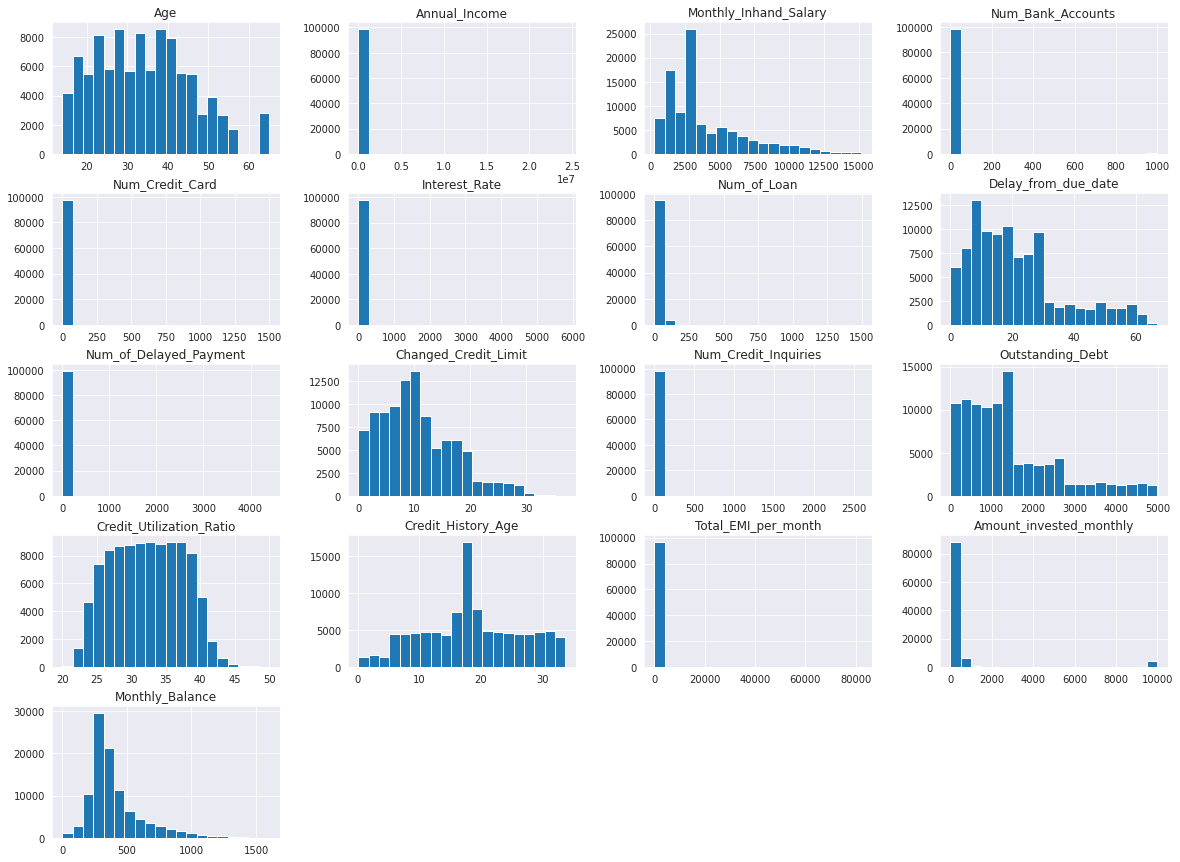

In [23]:
_ = train_df.hist(bins=20, figsize=(20, 15))

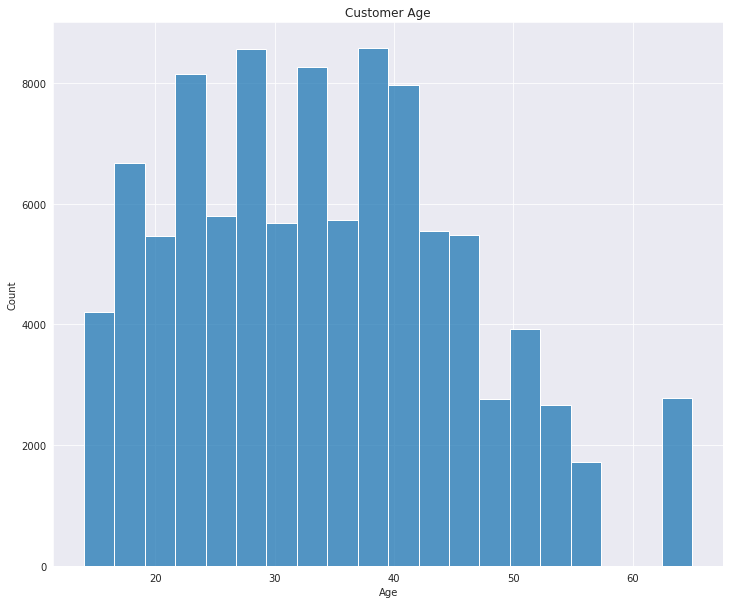

In [24]:
plt.figure(figsize=(12,10))
sns.histplot(train_df["Age"], bins=20)
plt.title('Customer Age')
plt.savefig("figures/ch6_credit_age.png", dpi=600)

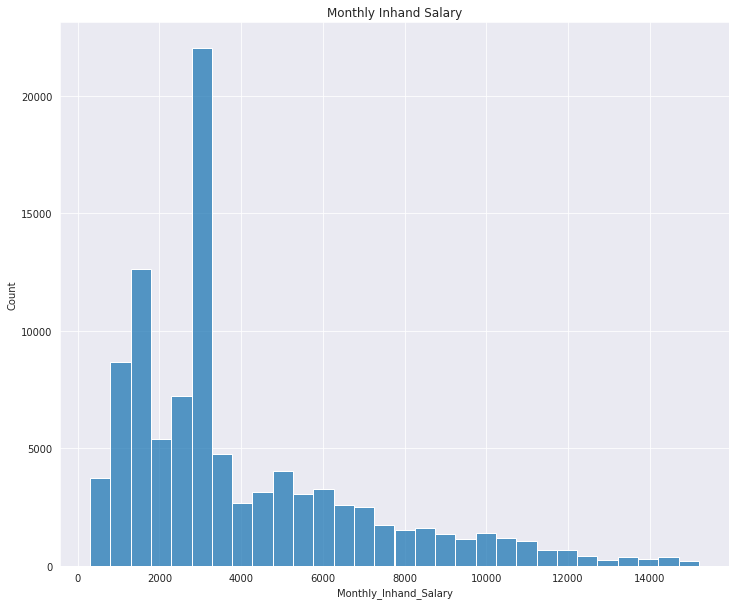

In [25]:
plt.figure(figsize=(12,10))
sns.histplot(train_df["Monthly_Inhand_Salary"], bins=30)
plt.title('Monthly Inhand Salary')
plt.savefig("figures/ch6_credit_salary.png", dpi=600)

<AxesSubplot:xlabel='Month', ylabel='Count'>

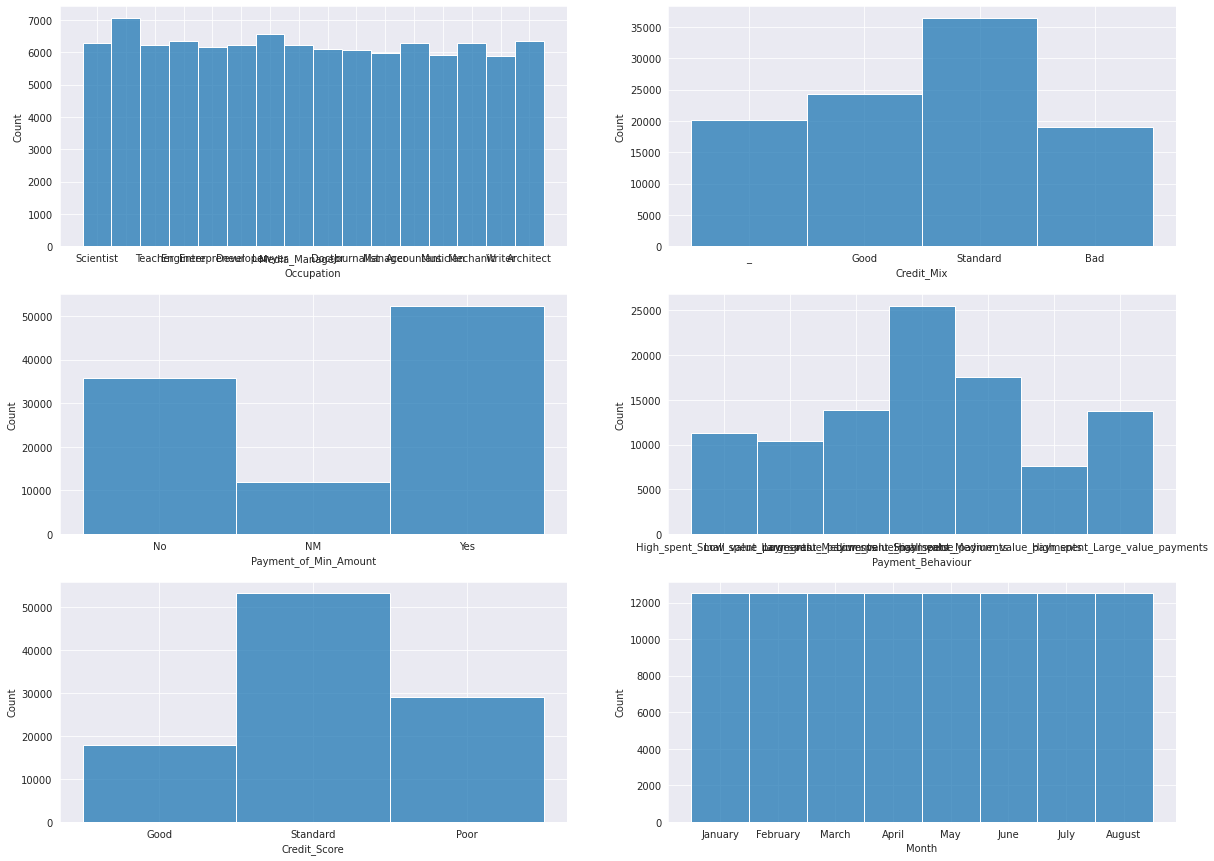

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
sns.histplot(train_df['Occupation'], ax=axes[0, 0])
sns.histplot(train_df['Credit_Mix'], ax=axes[0, 1])
sns.histplot(train_df['Payment_of_Min_Amount'], ax=axes[1, 0])
sns.histplot(train_df['Payment_Behaviour'], ax=axes[1, 1])
sns.histplot(train_df['Credit_Score'], ax=axes[2, 0])
sns.histplot(train_df['Month'], ax=axes[2, 1])

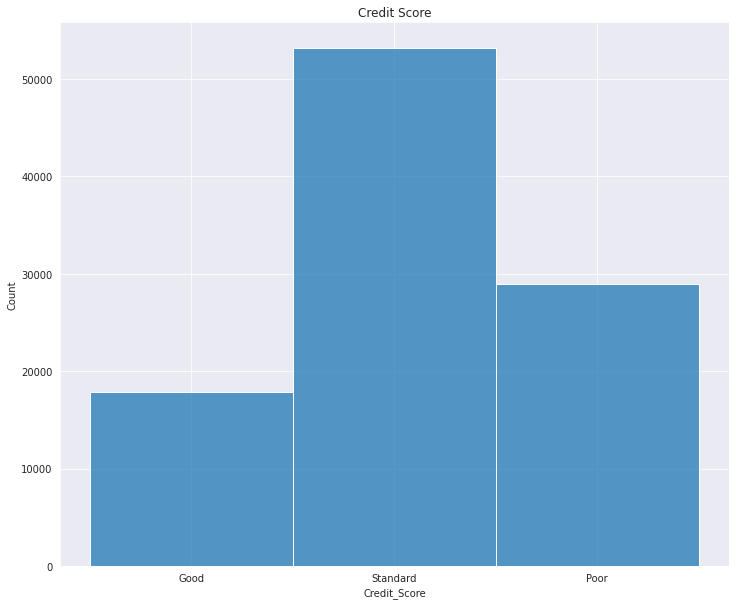

In [27]:
plt.figure(figsize=(12,10))
sns.histplot(train_df["Credit_Score"], bins=30)
plt.title('Credit Score')
plt.savefig("figures/ch6_credit_score.png", dpi=600)

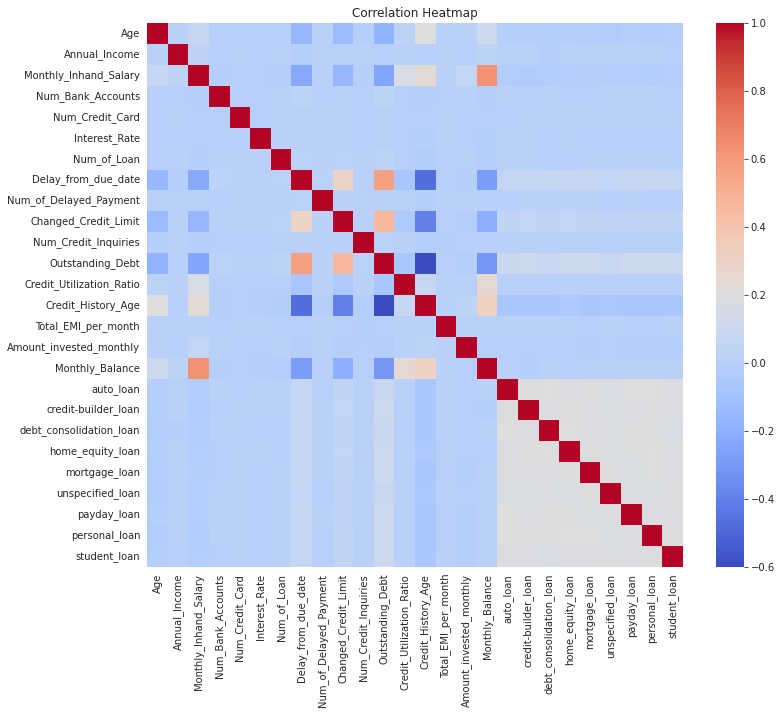

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig("figures/ch6_credit_correlations.png", dpi=600)

<AxesSubplot:xlabel='Credit_Score'>

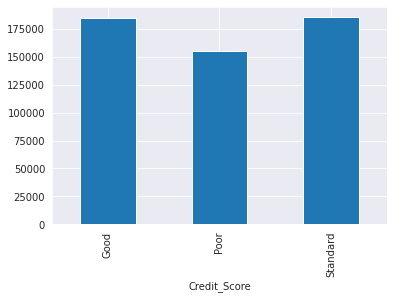

In [29]:
train_df.groupby("Credit_Score")["Annual_Income"].mean().plot.bar()

<AxesSubplot:xlabel='Credit_Score'>

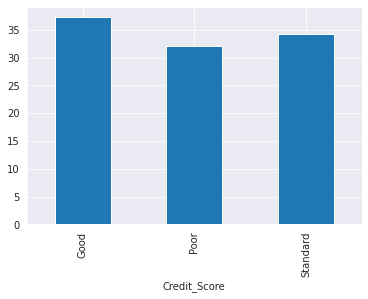

In [30]:
train_df.groupby("Credit_Score")["Age"].mean().plot.bar()

<AxesSubplot:xlabel='Age', ylabel='Annual_Income'>

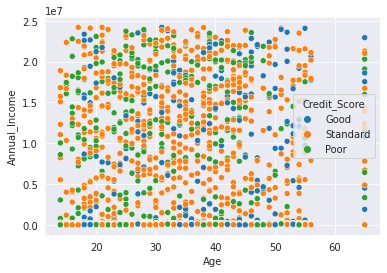

In [31]:
sns.scatterplot(x='Age',y='Annual_Income',hue='Credit_Score',data=train_df)

<AxesSubplot:xlabel='Age', ylabel='Monthly_Inhand_Salary'>

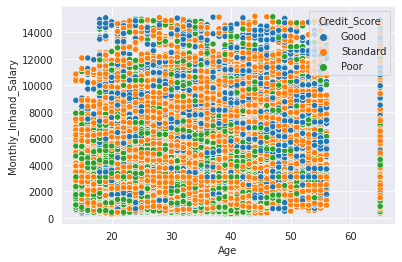

In [32]:
sns.scatterplot(x='Age',y='Monthly_Inhand_Salary',hue='Credit_Score',data=train_df)

<AxesSubplot:xlabel='Num_of_Delayed_Payment', ylabel='Credit_History_Age'>

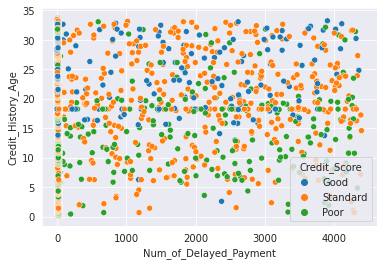

In [33]:
sns.scatterplot(x='Num_of_Delayed_Payment',y='Credit_History_Age',hue='Credit_Score',data=train_df)

<AxesSubplot:xlabel='Monthly_Inhand_Salary', ylabel='Monthly_Balance'>

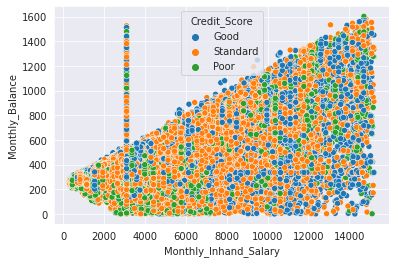

In [34]:
sns.scatterplot(x='Monthly_Inhand_Salary',y='Monthly_Balance',hue='Credit_Score',data=train_df)

<AxesSubplot:xlabel='Delay_from_due_date', ylabel='Outstanding_Debt'>

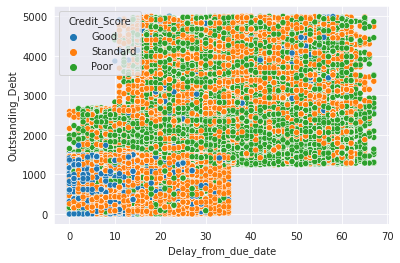

In [35]:
sns.scatterplot(x='Delay_from_due_date',y='Outstanding_Debt',hue='Credit_Score',data=train_df)

<AxesSubplot:xlabel='Monthly_Inhand_Salary', ylabel='Outstanding_Debt'>

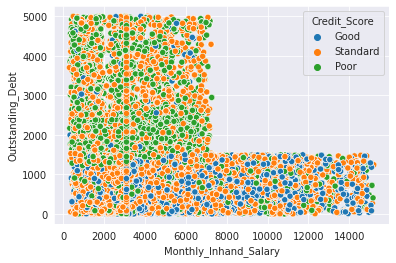

In [36]:
sns.scatterplot(x='Monthly_Inhand_Salary',y='Outstanding_Debt',hue='Credit_Score',data=train_df)

<AxesSubplot:xlabel='Annual_Income', ylabel='Outstanding_Debt'>

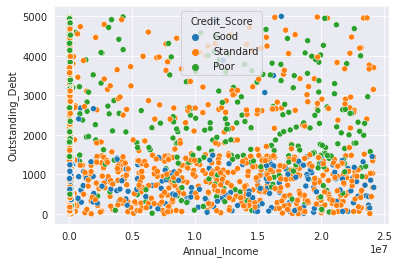

In [37]:
sns.scatterplot(x='Annual_Income',y='Outstanding_Debt',hue='Credit_Score',data=train_df)

## Data Preparation

In [55]:
def prepare_data(frame, test=False):
    for feature in categorical_columns:
        if test and feature == 'Credit_Score':
            break
        frame[feature] = pd.Series(frame[feature], dtype="category")
    if not test:
        X = train_df.drop(columns=["Credit_Score"], axis=1)
    else:
        X = train_df
    X_dummies = pd.get_dummies(X)
    if not test:
        y = train_df["Credit_Score"]
        smote = SMOTE(sampling_strategy='auto')
        return smote.fit_resample(X_dummies, y)
    return X_dummies

In [39]:
X, y = prepare_data(train_df)

In [40]:
y.value_counts(normalize=True)

Good        0.333333
Poor        0.333333
Standard    0.333333
Name: Credit_Score, dtype: float64

## Modeling

In [40]:
tree = DecisionTreeClassifier()
scores = cross_val_score(tree, X, y, scoring="accuracy")
print(f"Accuracy: {scores.mean()}")
scores = cross_val_score(tree, X, y, scoring="f1_macro")
print(f"F1: {scores.mean()}")

Accuracy: 0.699509956173174
F1: 0.697765503904938


In [41]:
forest = RandomForestClassifier()
scores = cross_val_score(forest, X, y, scoring="accuracy")
print(f"Accuracy: {scores.mean()}")
scores = cross_val_score(forest, X, y, scoring="f1_macro")
print(f"F1: {scores.mean()}")

Accuracy: 0.7734489799912195
F1: 0.7711447060258645


In [42]:
lgbm = lgb.LGBMClassifier(force_row_wise=True, verbose = -1)
scores = cross_val_score(lgbm, X, y, scoring="accuracy")
print(f"Accuracy: {scores.mean()}")
scores = cross_val_score(lgbm, X, y, scoring="f1_macro")
print(f"F1: {scores.mean()}")

KeyboardInterrupt: 

## Parameter Optimization

In [43]:
def objective(trial):
    boosting_type = trial.suggest_categorical("boosting_type", ["dart", "gbdt"])
    lambda_l1 = trial.suggest_float(
        'lambda_l1', 1e-8, 10.0, log=True),
    lambda_l2 = trial.suggest_float(
        'lambda_l2', 1e-8, 10.0, log=True),
    num_leaves = trial.suggest_int(
        'num_leaves', 2, 256),
    feature_fraction = trial.suggest_float(
        'feature_fraction', 0.4, 1.0),
    bagging_fraction = trial.suggest_float(
        'bagging_fraction', 0.4, 1.0),
    bagging_freq = trial.suggest_int(
        'bagging_freq', 1, 7),
    min_child_samples = trial.suggest_int(
        'min_child_samples', 5, 100),
    learning_rate = trial.suggest_float(
        "learning_rate", 0.0001, 0.5, log=True),
    max_bin = trial.suggest_int(
        "max_bin", 128, 512, 32)
    n_estimators = trial.suggest_int(
        "n_estimators", 40, 400, 20)

    model = lgb.LGBMClassifier(
        force_row_wise=True,
        boosting_type=boosting_type,
        n_estimators=n_estimators,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        num_leaves=num_leaves,
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq,
        min_child_samples=min_child_samples,
        learning_rate=learning_rate,
        max_bin=max_bin,
        verbose=-1)
    scores = cross_val_score(model, X, y, scoring="f1_macro")
    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler()
pruner = optuna.pruners.HyperbandPruner(
    min_resource=20, max_resource=400, reduction_factor=3)

study = optuna.create_study(
    direction='maximize', sampler=sampler,
    pruner=pruner
)
study.optimize(objective, n_trials=50, gc_after_trial=True, n_jobs=-1)

[I 2023-05-12 17:43:41,410] A new study created in memory with name: no-name-635bed8e-3174-4672-975d-436f2cc73aec
[I 2023-05-12 17:44:43,271] Trial 6 finished with value: 0.74387052717548 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.00014018048524562117, 'lambda_l2': 9.255722539188664, 'num_leaves': 45, 'feature_fraction': 0.690576901366643, 'bagging_fraction': 0.7212881483099698, 'bagging_freq': 4, 'min_child_samples': 91, 'learning_rate': 0.15307689795593607, 'max_bin': 256, 'n_estimators': 40}. Best is trial 6 with value: 0.74387052717548.
[I 2023-05-12 17:45:51,226] Trial 4 finished with value: 0.7420266619450923 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.016792911790613627, 'lambda_l2': 7.632243747376821e-08, 'num_leaves': 143, 'feature_fraction': 0.9253988758784171, 'bagging_fraction': 0.6023819523068774, 'bagging_freq': 1, 'min_child_samples': 76, 'learning_rate': 0.0005125435509909271, 'max_bin': 256, 'n_estimators': 40}. Best is trial 6 with value: 0.

In [ ]:
print(study.best_trial)

## Train model using best results

In [57]:
model = lgb.LGBMClassifier(
        force_row_wise=True,
        boosting_type='gbdt',
        n_estimators=180,
        lambda_l1=1.721e-06,
        lambda_l2=2.794e-05,
        num_leaves=243,
        feature_fraction=0.53218,
        bagging_fraction=0.63274,
        bagging_freq=4,
        min_child_samples=98,
        learning_rate=0.0474,
        max_bin=160,
        verbose=-1
)
scores = cross_val_score(model, X, y, scoring="accuracy")
print(f"Accuracy: {scores.mean()}")
scores = cross_val_score(model, X, y, scoring="f1_macro")
print(f"F1: {scores.mean()}")
model = model.fit(X, y)

Accuracy: 0.7641341767427341
F1: 0.7631000551618455


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

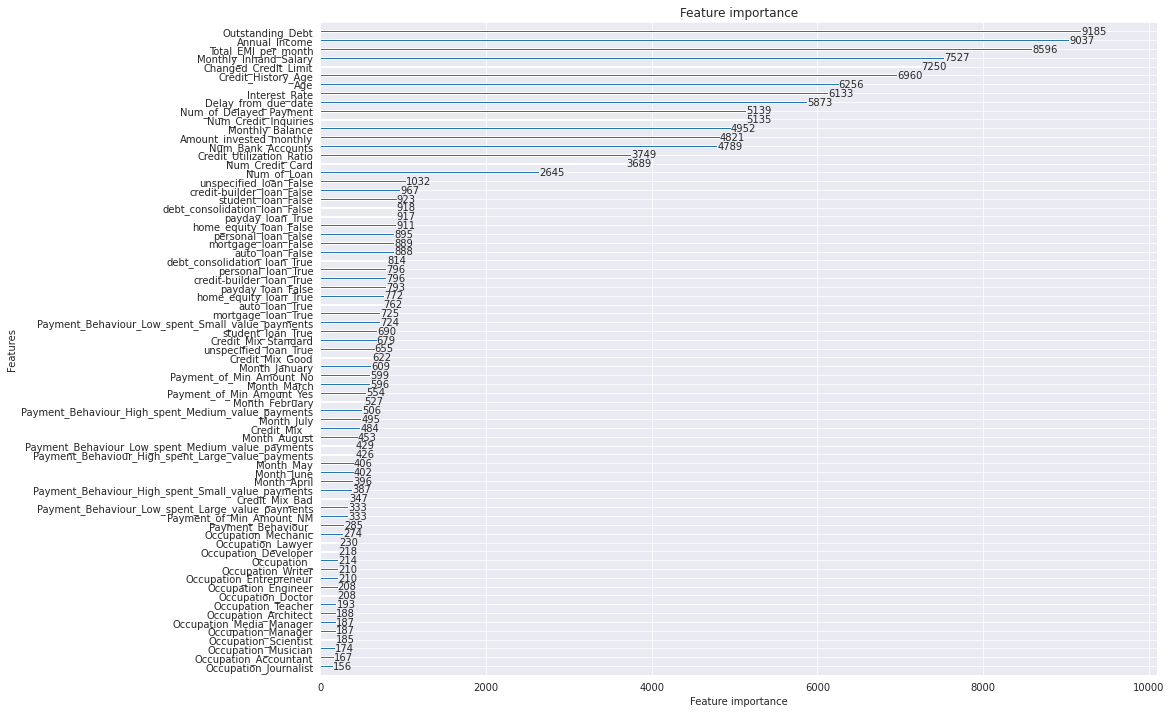

In [48]:
lgb.plot_importance(model, figsize=(15, 12))

### Saving the model

In [45]:
joblib.dump(model, "lgb_credit_score_classification.pkl")

['lgb_credit_score_classification.pkl']

In [46]:
def make_predictions(data):
    model = joblib.load("lgb_credit_score_classification.pkl")
    return model.predict(data)

In [56]:
make_predictions(prepare_data(pd.read_csv("creditscore/test.csv"), test=True))

ValueError: Number of features of the model must match the input. Model n_features_ is 73 and input n_features is 76